In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pandas as pd
import os
import plotly.express as px
import plotly.graph_objs as go
import plotly
from copy import deepcopy

import sys
project_path = r'E:\pirate_fmri\Analysis'
sys.path.append(project_path)

from zpyhelper.filesys import checkdir
from zpyhelper.MVPA.rdm import compute_rdm,lower_tri,upper_tri, compute_rdm_nomial, compute_rdm_identity
from zpyhelper.MVPA.preprocessors import scale_feature, average_odd_even_session,normalise_multivariate_noise, split_data, concat_data


Let $x_j\in\R^{4}$ be the vector of one feature of stimulus $j$, and $X = [x_1,x_2,x_3,x_4]^{T}, X\in\R^{n\times4}$ the matrix containing feature vectors of stimuli.  
We know a projection matrix $P_x$ that project feature $x$ onto the output space:
$P_x = [p_x,u_{x1},u_{x2},u_{x3}]$, where $p_x = [-2,-1,1,2,0,0,0,0]$, and $u_{xk}$ are all orthogonal to each other and to $p_x$

Similarly, we have $y_j\in\R^{4}$ be another feature vecotor of stimulus $j$, and $Y = [y_1,y_2,y_3,y_4]^{T}, Y\in\R^{n\times4}$ another matrix of all stimuli.  
We know a second projection matrix $P_y$ that project feature $y$ onto the output space:
$P_y = [p_y,u_{y1},u_{y2},u_{y3}]$, where $p_y = [0,0,0,0,-2,-1,1,2]$, and $u_{yk}$ are all orthogonal to each other and to $p_y$


We seek to find the rotation matrix $M_\theta$ such that:  
the angle between $p_x^T \times M_\theta $ and $p_y^T$ is $\theta$

In [2]:
def get_angle(a,b):
    return np.rad2deg(np.arccos(1-scipy.spatial.distance.cosine(a,b)))
def rotation_mat_2D(theta):
    # clockwise rotation
    M = np.array([[np.cos(theta), -np.sin(theta)],
		         [np.sin(theta), -np.cos(theta)]]) 
    return M

a = np.array([1,0])	
b = np.array([0,1])
print("angle between a,b: ", get_angle(a,b))

print("angle between a,b@M(60): ", get_angle(a,b@rotation_mat_2D(np.pi/3)))

angle between a,b:  90.0
angle between a,b@M(60):  30.000000000000004


In [3]:
px = [-2,-1,1,2,0,0,0,0]
py = [0,0,0,0,-2,-1,1,2]
unit_px = px/np.linalg.norm(px)
unit_py = py/np.linalg.norm(py)

get_angle(unit_px,unit_py)

# unit_px and unit_py define a plane, all the points in the plane can be defined 
# by a set of coordinates (r,s), and this set of coordinates corresponds 
# to a vector: vec = r*unit_px + s*unit_py
# rotating a given vector defined by (r,s) is essentially rotating the 
# 2D coordinate vector(r,s) within this plane
basis = np.array([unit_px,unit_py])

coord = np.array([[0,1]]) #r,s
vec = coord@basis
print("angle between vec and unit_px: ", get_angle(unit_px,vec.squeeze()))

M_60 = rotation_mat_2D(np.pi/3)
vec_M_60 = coord@M_60@basis
print("angle between vec@M(60): ", get_angle(unit_px,vec_M_60.squeeze()))

angle between vec and unit_px:  90.0
angle between vec@M(60):  29.999999999999993


In [9]:
# so we can define the function for rotating vector as follow
def rotate_vec2(vec1,vec2,theta):
	vec1 = np.array(vec1)
	vec2 = np.array(vec2)
	# project vec2 onto vec1: decompose vec2 into a part that is parallel to vec1 and a part that is orthogonal to vec1:
	# i.e., vec2 = k*vec1 + vec1_orth
	k = np.dot(vec1,vec2)/np.dot(vec1, vec1)
	vec1_orth = vec2-k*vec1
	n1 = np.linalg.norm(vec1)
	n1o = np.linalg.norm(vec1_orth)
	unit_x = vec1/n1
	unit_y = vec1_orth/n1o
	
	basis = np.array([unit_x,unit_y])
	# so the coordinate of vec2 is essentially
	r = k*n1
	s = 1*n1o
	coord = np.array([[r,s]])
	
	# then we rotate within this 2D plane, and recalculate the rotated vec2
	M_theta = rotation_mat_2D(theta)
	vec2_theta = (coord@M_theta@basis)

	return vec2_theta.flatten()

px = [-2,-1,1,2,0,0,0,0]
py = [0,0,0,0,-2,-1,1,2]
print("Original Angle between vecs: ", get_angle(px,py))
for theta in [np.deg2rad(j*9) for j in np.arange(10)]+[-np.deg2rad(j*9) for j in np.arange(10)]:
	print(f"Rotate py clockwise by {np.rad2deg(theta)}, the new angle between vec@M({theta}): ", get_angle(px,rotate_vec2(px,py,theta)))

Original Angle between vecs:  90.0
Rotate py clockwise by 0.0, the new angle between vec@M(0.0):  90.0
Rotate py clockwise by 9.0, the new angle between vec@M(0.15707963267948966):  81.0
Rotate py clockwise by 18.0, the new angle between vec@M(0.3141592653589793):  72.0
Rotate py clockwise by 27.0, the new angle between vec@M(0.47123889803846897):  63.0
Rotate py clockwise by 36.0, the new angle between vec@M(0.6283185307179586):  54.0
Rotate py clockwise by 45.0, the new angle between vec@M(0.7853981633974483):  45.0
Rotate py clockwise by 54.0, the new angle between vec@M(0.9424777960769379):  35.99999999999997
Rotate py clockwise by 63.0, the new angle between vec@M(1.0995574287564276):  26.999999999999996
Rotate py clockwise by 72.0, the new angle between vec@M(1.2566370614359172):  17.999999999999986
Rotate py clockwise by 81.0, the new angle between vec@M(1.413716694115407):  8.999999999999943
Rotate py clockwise by -0.0, the new angle between vec@M(-0.0):  90.0
Rotate py clockwi

In [46]:
stim_mat

array([[1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]])

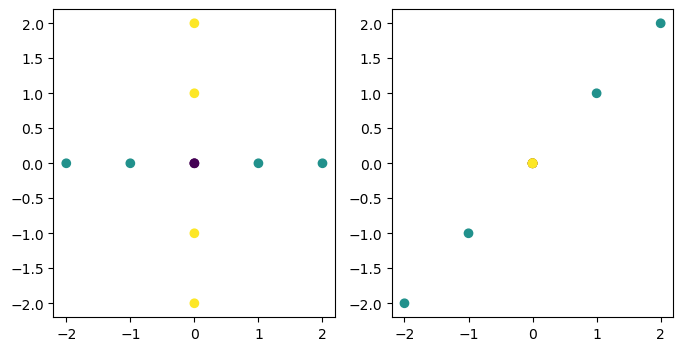

In [49]:
# let's test with projection
px = [-2,-1,0,1,2,0,0,0,0,0]
py = [0,0,0,0,0,-2,-1,0,1,2]
stim_mat = np.vstack([[np.hstack([f1,f2]) for f1,f2 in itertools.product(np.eye(5),np.eye(5)[[2]])],
                      [np.hstack([f1,f2]) for f1,f2 in itertools.product(np.eye(5)[[2]],np.eye(5))]])
readout = stim_mat@(np.array([px,py]).T)

plt.subplots(1,2,figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(readout[:,0],readout[:,1],c=[1,1,0,1,1,2,2,0,2,2])
plt.subplot(1,2,2)
readout2 = stim_mat@(np.array([px,rotate_vec2(px,py, np.pi/2)]).T)
plt.scatter(readout2[:,0],readout2[:,1],c=[1,1,0,1,1,2,2,0,2,2])

In [19]:
# let's test with projection
def create_unitary_fixedfirst(v):
    """create a unitary matrix with a given first column vector using Householder transformation
    
    Formula:
    https://math.stackexchange.com/a/4160071
    Implementation:
    https://math.stackexchange.com/q/4160055

    Parameters
    ----------
    v : 1d numpy array
        one d numpy array which will be the first column vector

    Returns
    -------
    numpy.ndarray
        a unitary matrix
    """
    if np.ndim(v)==1:
        v = np.atleast_2d(v).T
    elif np.ndim(v)==2:
        v = np.array(v)
    else:
        v = np.atleast_2d(np.array(v).flatten).T
   
    dim = v.size
    # Return identity if v is a multiple of e = (1,0,0,0,0).T
    if v[0,0] and not np.any(v[1:,0]): #v[0,0]: first element is 1; not np.any(v[1:,0]): 2nd to last element are not all zeros
        return np.identity(dim)
    elif not np.any(v):
        return np.zeros((dim,dim))
    e1 = np.zeros((dim,1))
    e1[0] = 1
    w = v/np.linalg.norm(v) - e1
    return np.identity(dim) - 2*((np.dot(w, w.T))/(np.dot(w.T, w)))

def compute_projection_matrix_singlefeature(v,betas,var_ratio):
    var = np.linalg.norm(v)*var_ratio
    one_d_proj   = np.atleast_2d(v).T
    # generate a unitary matrix to perform location-preserving rigid transformation 
    # with p as the first basis, in this way, the original representation will be transformed into 
    # a new coordinate system where the first axis will be the one relevant for readout
    U = create_unitary_fixedfirst(one_d_proj)
    # non-uniform scaling of axis controlled by the compression parameter
    S = np.array([1-np.sum(betas),betas[0],betas[1],betas[2]])*var
    # compute the projection matrix
    projection_mat = U*S
    return projection_mat


def compute_compression_matrix_twofeature(beta_x,beta_y,var_ratio):
    """_summary_

    Parameters
    ----------
    beta_x : float
       compression of x
    beta_y : float
       compression of y
    var_ratio: float
        x variance ratio, `var_ratio = var_x/(var_x+var_y)`
    alpha: float
        angle between x and y axis
    nval : int
        number of values in x/y

    Returns
    -------
    numpy.ndarray
        projection matrix
    """
    v = np.array([-2,-1,1,2])
    proj_color = compute_projection_matrix_singlefeature(v,beta_x,var_ratio)
    proj_shape = compute_projection_matrix_singlefeature(v,beta_y,1-var_ratio)
    proj_xy = np.hstack([proj_color,proj_shape])
    return proj_xy

<Axes: >

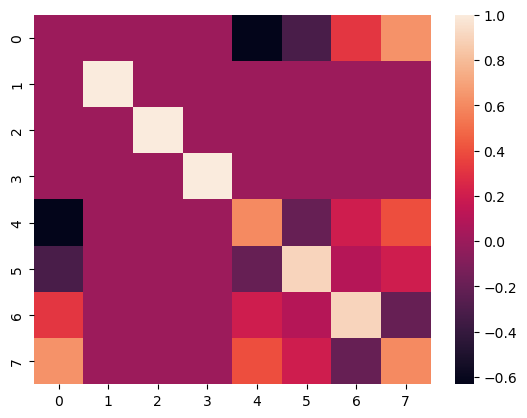

In [24]:
sns.heatmap(create_unitary_fixedfirst(py))

In [20]:
compute_projection_matrix_singlefeature(px,[0,0,0],0.5)

ValueError: operands could not be broadcast together with shapes (8,8) (4,) 

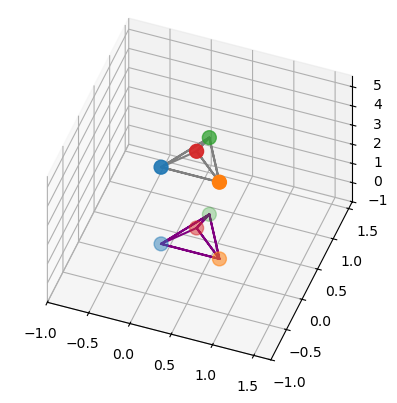

In [13]:
# let's test this in tetrahedrons
tetrahedron_1 = np.array([
    [0,            0,            0],
    [np.sqrt(2),   0,            0],
    [np.sqrt(2)/2, np.sqrt(6)/2, 0],
    [np.sqrt(2)/2, np.sqrt(6)/6, 2*np.sqrt(3)/3]]
)*0.5

tetrahedron_2 = deepcopy(tetrahedron_1)
tetrahedron_2[:,2] = tetrahedron_1[:,2]+4

tetra_df = pd.DataFrame(np.concatenate([tetrahedron_1,tetrahedron_2],axis=0),columns=["x","y","z"])
tetra_df["id"] = [1,2,3,4,1,2,3,4]
tetrahuedict = dict(zip([1,2,3,4],sns.color_palette(None,4)))

tetra_ax = plt.figure().add_subplot(projection='3d')
tetra_ax.set_proj_type('ortho')
tetra_ax.set(xlim=(tetra_df.x.min()-1, tetra_df.x.max()+1), ylim=(tetra_df.y.min()-1, tetra_df.y.max()+1), zlim = (tetra_df.z.min()-1, tetra_df.z.max()+1))
tetra_ax.view_init(elev=45, azim=-70, roll=None)
tetra_ax.scatter(xs=tetra_df.x,ys=tetra_df.y,zs=tetra_df.z,c=[tetrahuedict[i] for i in tetra_df.id],s=100)
pair_idx = np.array(list(itertools.combinations(range(tetrahedron_1.shape[0]),2))).flatten()
tetra_ax.plot(xs=tetra_df.x[pair_idx],ys=tetra_df.y[pair_idx],zs=tetra_df.z[pair_idx],c="purple")
pair_idx = np.array(list(itertools.combinations(range(tetrahedron_1.shape[0]),2))).flatten()+4
tetra_ax.plot(xs=tetra_df.x[pair_idx],ys=tetra_df.y[pair_idx],zs=tetra_df.z[pair_idx],c="grey")

In [ ]:
tetrahedron_2 

C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_24648\2450992407.py:7: RuntimeWarning: invalid value encountered in scalar divide
  k = np.dot(vec1,vec2)/np.dot(vec1, vec1)
C:\Users\Zilu Liang\AppData\Local\Temp\ipykernel_24648\2450992407.py:11: RuntimeWarning: invalid value encountered in divide
  unit_x = vec1/n1


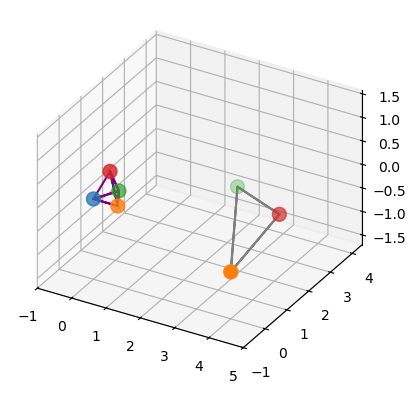

In [ ]:
tetrahedron_3 = np.vstack([rotate_vec2(vec1,vec2,np.pi/2) for vec1,vec2 in zip(tetrahedron_1,tetrahedron_2)])
tetra_df = pd.DataFrame(np.concatenate([tetrahedron_1,tetrahedron_3],axis=0),columns=["x","y","z"])
tetra_df["id"] = [1,2,3,4,1,2,3,4]
tetrahuedict = dict(zip([1,2,3,4],sns.color_palette(None,4)))

tetra_ax = plt.figure().add_subplot(projection='3d')
tetra_ax.set_proj_type('ortho')
tetra_ax.set(xlim=(tetra_df.x.min()-1, tetra_df.x.max()+1), ylim=(tetra_df.y.min()-1, tetra_df.y.max()+1), zlim = (tetra_df.z.min()-1, tetra_df.z.max()+1))
#tetra_ax.view_init(elev=45, azim=-70, roll=None)
tetra_ax.scatter(xs=tetra_df.x,ys=tetra_df.y,zs=tetra_df.z,c=[tetrahuedict[i] for i in tetra_df.id],s=100)
pair_idx = np.array(list(itertools.combinations(range(tetrahedron_1.shape[0]),2))).flatten()
tetra_ax.plot(xs=tetra_df.x[pair_idx],ys=tetra_df.y[pair_idx],zs=tetra_df.z[pair_idx],c="purple")
pair_idx = np.array(list(itertools.combinations(range(tetrahedron_1.shape[0]),2))).flatten()+4
tetra_ax.plot(xs=tetra_df.x[pair_idx],ys=tetra_df.y[pair_idx],zs=tetra_df.z[pair_idx],c="grey")